# Part B: Exploration + Data Preprocessing

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)

Booking data treatment

In [121]:
original_booking_data = pd.read_csv('scraped_data/booking_data.csv')
original_booking_data.head(3)

print(f'Shape for booking data: {original_booking_data.shape}')
print(f'Nulls before eliminating: \n{original_booking_data.isnull().sum()}')

booking_data = original_booking_data.drop(['Card Deal'], axis=1) # Decided to eliminate this column since more than 80% of the data is missing
booking_data = booking_data[booking_data['Payment Policy'].notnull()]
booking_data = booking_data[booking_data['Cancellation Policy'].notnull()]
booking_data = booking_data[booking_data['Bed Type'].notnull()]

print(f'\nNulls after treatment: {booking_data.isnull().sum().sum()}')
print(f'Shape for booking data after treatment: {booking_data.shape}')

booking_data['Date of search'] = pd.to_datetime(booking_data['Date of search'])
booking_data['Checkin'] = pd.to_datetime(booking_data['Checkin'])
booking_data['Checkout'] = pd.to_datetime(booking_data['Checkout'])

booking_data.head(2)

Shape for booking data: (11791, 20)
Nulls before eliminating: 
Hotel Name                0
Score                     0
Distance to Center        0
Price                     0
Taxes and Fees            0
Total Price               0
Nights and Adults         0
Card Deal              9355
Stars                     1
Subway Access             0
Neighborhood              0
Room Type                 0
Bed Type                 20
Cancellation Policy    4749
Payment Policy         6925
Review Class              0
Number of Reviews         0
Date of search            0
Checkin                   0
Checkout                  0
dtype: int64

Nulls after treatment: 0
Shape for booking data after treatment: (4849, 19)


,Hotel Name,Score,Distance to Center,Price,Taxes and Fees,Total Price,Nights and Adults,Stars,Subway Access,Neighborhood,Room Type,Bed Type,Cancellation Policy,Payment Policy,Review Class,Number of Reviews,Date of search,Checkin,Checkout
12,Courtyard by Marriott Times Square West,8.2,1.8,191,32,223.0,"1 night,2 adults",3.0,True,Hell's Kitchen,King Room,1 king bed,Free cancellation,No prepayment needed– pay at the property,Very Good,2790,2024-06-17,2024-06-18,2024-06-19
39,Courtyard by Marriott Times Square West,8.2,1.8,382,63,445.0,"2 nights,2 adults",3.0,True,Hell's Kitchen,King Room,1 king bed,Free cancellation,No prepayment needed– pay at the property,Very Good,2790,2024-06-17,2024-06-18,2024-06-20


Expedia data treatment

In [122]:
original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')

print(f'Shape for expedia data: {original_expedia_data.shape}')
print(f'Nulls before eliminating: \n{original_expedia_data.isnull().sum()}')

expedia_data = original_expedia_data.drop(columns=['Stay Type', 'Bed type'], axis=1) # TEMPORARY, THE CODE IS NOT RETRIEVING THIS WELL
expedia_data = expedia_data.dropna(subset=['Cancellation policy', 'Payment policy', 'Classification'])

print(f'\nNulls after treatment: {expedia_data.isnull().sum().sum()}')
print(f'Shape for expedia after treatment: {expedia_data.shape}')
expedia_data['Date of search'] = pd.to_datetime(expedia_data['Date of search'])
expedia_data['Checkin'] = pd.to_datetime(expedia_data['Checkin'])
expedia_data['Checkout'] = pd.to_datetime(expedia_data['Checkout'])

expedia_data['Price After Taxes'] = expedia_data['Price After Taxes'].replace(',', '', regex=True).astype(int)

# Changing column names for both booking and expedia
new_expedia_columns = [column.replace(' ', '_').lower() for column in expedia_data.columns]
new_booking_columns = [column.replace(' ', '_').lower() for column in booking_data.columns]

expedia_data.columns = new_expedia_columns
booking_data.columns = new_booking_columns

expedia_data.head(2)

Shape for expedia data: (36068, 15)
Nulls before eliminating: 
Hotel Name                 0
Price Before Taxes         0
Rating                     0
Classification           146
Reviews                    0
Stay Type              36068
Bed type               36068
Neighborhood               0
District                   0
Cancellation policy    26388
Payment policy         29715
Price After Taxes          0
Date of search             0
Checkin                    0
Checkout                   0
dtype: int64

Nulls after treatment: 0
Shape for expedia after treatment: (6208, 13)


,hotel_name,price_before_taxes,rating,classification,reviews,neighborhood,district,cancellation_policy,payment_policy,price_after_taxes,date_of_search,checkin,checkout
2,"PUBLIC, an Ian Schrager hotel",249,8.2,Very Good,2592,New York,New York,Fully refundable,"Reserve now, pay later",335,2024-06-17,2024-06-18,2024-06-19
7,Sonder The Dutch,273,9.0,Wonderful,69,Queens,Queens,Fully refundable,Fully refundable,292,2024-06-17,2024-06-18,2024-06-19


In [123]:
print(f'Expedia data columns: {expedia_data.columns}')
print(f'Booking data columns: {booking_data.columns}')

Expedia data columns: Index(['hotel_name', 'price_before_taxes', 'rating', 'classification',
       'reviews', 'neighborhood', 'district', 'cancellation_policy',
       'payment_policy', 'price_after_taxes', 'date_of_search', 'checkin',
       'checkout'],
      dtype='object')
Booking data columns: Index(['hotel_name', 'score', 'distance_to_center', 'price', 'taxes_and_fees',
       'total_price', 'nights_and_adults', 'stars', 'subway_access',
       'neighborhood', 'room_type', 'bed_type', 'cancellation_policy',
       'payment_policy', 'review_class', 'number_of_reviews', 'date_of_search',
       'checkin', 'checkout'],
      dtype='object')


- Creating for both expedia and booking data distribution graphs of:
1. Number of reviews
2. Hotel rating in reviews
3. Prices

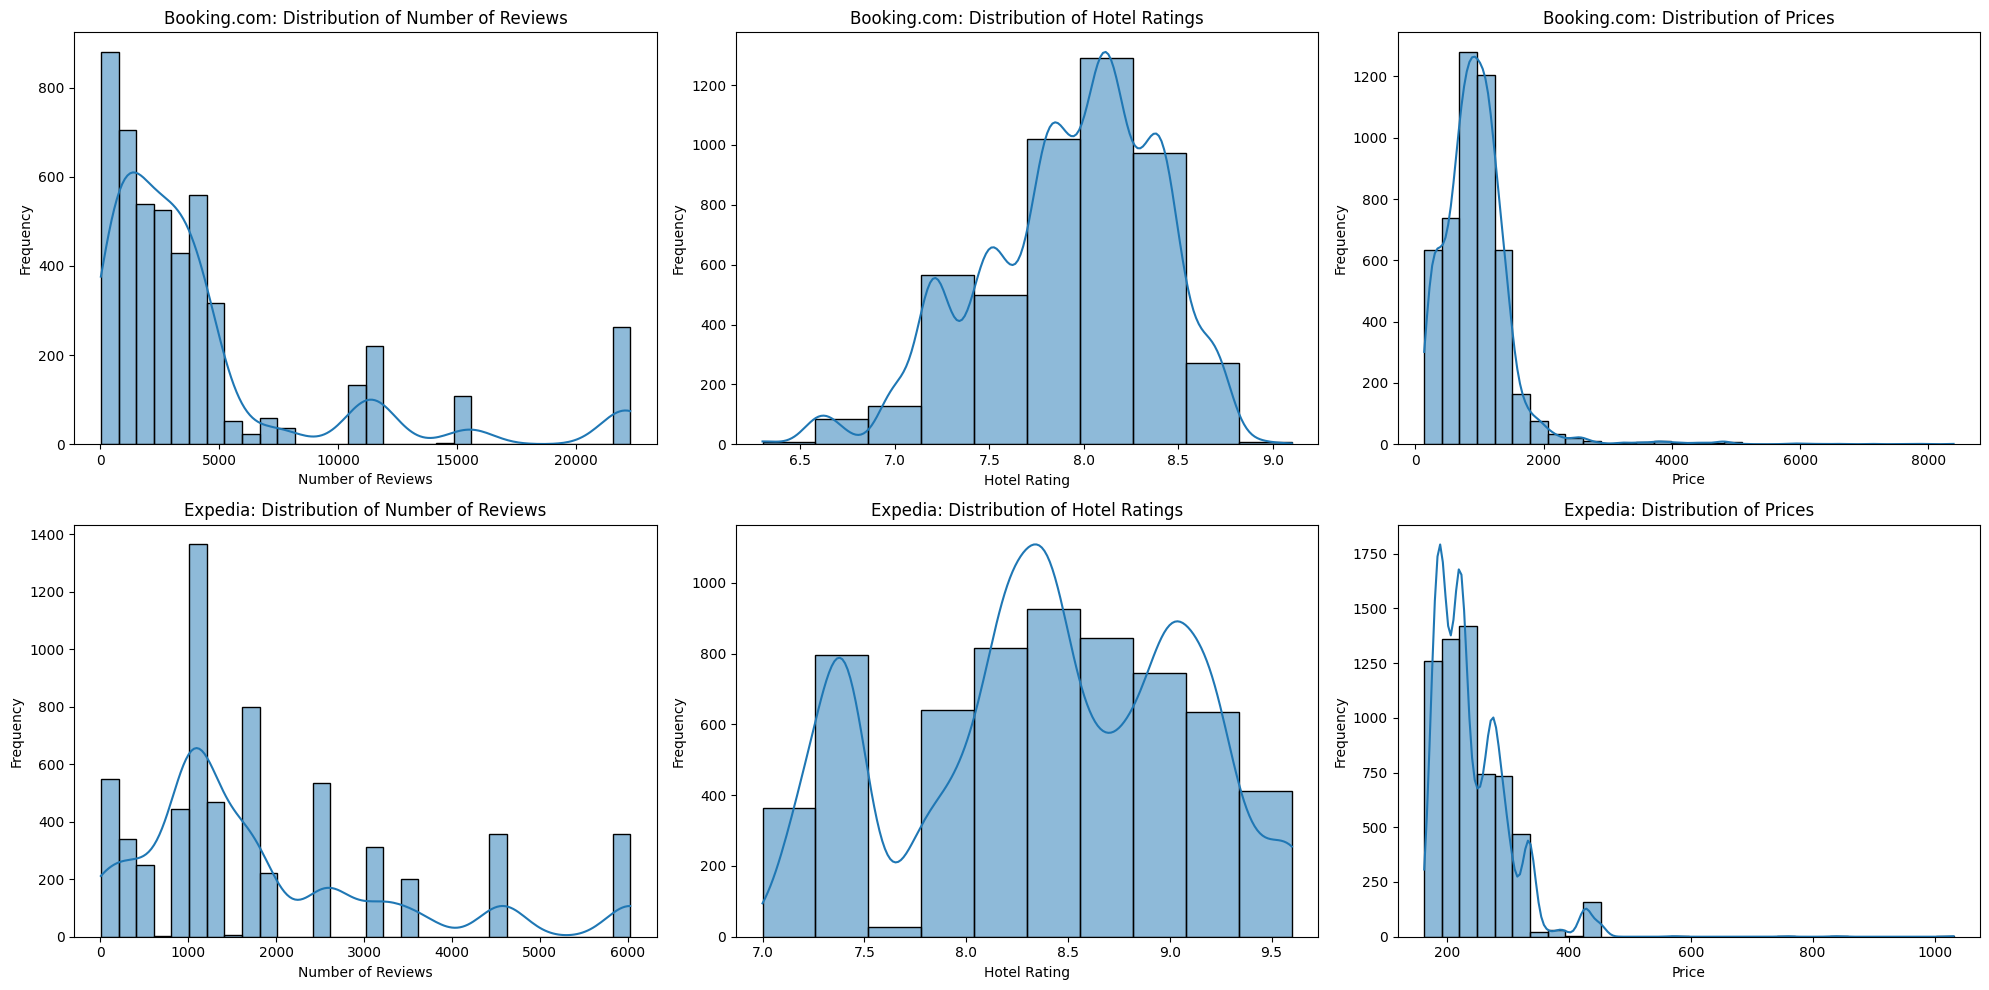

In [124]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Booking.com data plots
# 1. Number of reviews
sns.histplot(booking_data['number_of_reviews'].astype(int), bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Booking.com: Distribution of Number of Reviews')
axs[0, 0].set_xlabel('Number of Reviews')
axs[0, 0].set_ylabel('Frequency')

# 2. Hotel rating in reviews
sns.histplot(booking_data['score'].astype(float), bins=10, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Booking.com: Distribution of Hotel Ratings')
axs[0, 1].set_xlabel('Hotel Rating')
axs[0, 1].set_ylabel('Frequency')

# 3. Prices
sns.histplot(booking_data['total_price'].astype(float), bins=30, kde=True, ax=axs[0, 2])
axs[0, 2].set_title('Booking.com: Distribution of Prices')
axs[0, 2].set_xlabel('Price')
axs[0, 2].set_ylabel('Frequency')

# Expedia data plots
# 1. Number of reviews
sns.histplot(expedia_data['reviews'].astype(int), bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Expedia: Distribution of Number of Reviews')
axs[1, 0].set_xlabel('Number of Reviews')
axs[1, 0].set_ylabel('Frequency')

# 2. Hotel rating in reviews
sns.histplot(expedia_data['rating'].astype(float), bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Expedia: Distribution of Hotel Ratings')
axs[1, 1].set_xlabel('Hotel Rating')
axs[1, 1].set_ylabel('Frequency')

# 3. Prices
sns.histplot(expedia_data['price_after_taxes'].astype(float), bins=30, kde=True, ax=axs[1, 2])
axs[1, 2].set_title('Expedia: Distribution of Prices')
axs[1, 2].set_xlabel('Price')
axs[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- Remove from data hotels that based on price column are an outlier (using 
Tukey 1.5IQR method).

In [125]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

booking_data_no_outliers = remove_outliers(booking_data, 'total_price')
expedia_data_no_outliers = remove_outliers(expedia_data, 'price_after_taxes')

print(f'Booking data shape without outliers: {booking_data_no_outliers.shape}')
print(f'Expedia data shape without outliers: {expedia_data_no_outliers.shape}')

Booking data shape without outliers: (4720, 19)
Expedia data shape without outliers: (6038, 13)


- Convert variables with Ordinal characteristic to numbers with order relation 
(for example Good < Very Good<Excellent)

Booking data

In [126]:
# Change here the values
booking_data_no_outliers = booking_data_no_outliers.copy()
print(f'Unique values for review class before treatment: {booking_data_no_outliers["review_class"].unique()}')

# Eliminating all the rows where Review Class column says 'Review score'
booking_data_no_outliers = booking_data_no_outliers[booking_data_no_outliers['review_class'] != 'Review score'] # Eliminating all the rows where Review Class column says 'Review score'

ordinal_mapping = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
}

booking_data_no_outliers['review_class'] = booking_data_no_outliers['review_class'].map(ordinal_mapping)
print(f'Unique values for review class after treatment: {booking_data_no_outliers["review_class"].unique()}')

Unique values for review class before treatment: ['Very Good' 'Good' 'Excellent' 'Review score']
Unique values for review class after treatment: [2 1 3]


Expedia data

In [127]:
# Make a copy of the DataFrame
expedia_data_no_outliers = expedia_data_no_outliers.copy()
print(f'Unique values for review class before treatment: {expedia_data_no_outliers["classification"].unique()}')

# Eliminating all the rows where Review Class column says 'Review score'
ordinal_mapping = {
    'Good': 0,
    'Very Good': 1,
    'Excellent': 2,
    'Wonderful': 3,
    'Exceptional': 4,
}
expedia_data_no_outliers['classification'] = expedia_data_no_outliers['classification'].map(ordinal_mapping)
print(f'Unique values for review class after treatment: {expedia_data_no_outliers["classification"].unique()}')

Unique values for review class before treatment: ['Very Good' 'Wonderful' 'Good' 'Excellent' 'Exceptional']
Unique values for review class after treatment: [1 3 0 2 4]


- Additional example – the bed type by order relation. First you have to 
calculate the bed types (distinct) out of total data you have). And then King 
Room should get higher value then Queen Room for example.

Since there are many different types of beds retrieven from the scraping, I have decided to encode these columns too in the following part of the project requirements.

Booking data

In [128]:
def one_hot_encode(df, columns_to_encode):
    # One-hot encode the columns
    encoder = OneHotEncoder(drop='first')
    encoded_data = encoder.fit_transform(df[columns_to_encode])

    # Get the correct feature names after encoding
    feature_names = encoder.get_feature_names_out(input_features=columns_to_encode)

    # Create a DataFrame with the encoded data and the correct feature names
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)

    # Merge with original dataframe
    data = df.drop(columns=columns_to_encode).reset_index(drop=True)
    data = pd.concat([data, encoded_df], axis=1)
    
    return data

# One-hot encode the columns of expedia and booking data
columns_to_encode_booking = ['hotel_name', 'nights_and_adults', 'neighborhood', 'room_type', 'bed_type', 'cancellation_policy', 'payment_policy']
columns_to_encode_expedia = ['hotel_name', 'neighborhood', 'district', 'cancellation_policy', 'payment_policy']

booking_data_encoded = one_hot_encode(booking_data_no_outliers, columns_to_encode_booking)
expedia_data_encoded = one_hot_encode(expedia_data_no_outliers, columns_to_encode_expedia)

print(f'Shape of booking data after encoding: {booking_data_encoded.shape}')
print(f'Shape of expedia data after encoding: {expedia_data_encoded.shape}')

Shape of booking data after encoding: (4630, 264)
Shape of expedia data after encoding: (6038, 88)


- PairGrid (of seaborn library) for the variables in booking and expedia data.

Booking data numerical variables pairplot

In [129]:
# booking_data_columns_pairgrid = ['score', 'distance_to_center', 'price', 'taxes_and_fees', 'stars', 'subway_access', 'review_class', 'number_of_reviews', 'total_price']

# # Create a PairGrid object
# grid = sns.PairGrid(data=booking_data_encoded[booking_data_columns_pairgrid])

# # Map a scatter plot to the upper triangle
# grid = grid.map_lower(plt.scatter, color='darkred')

# # Map a KDE plot to the diagonal
# grid = grid.map_diag(sns.kdeplot, lw=2, color='darkred')

# plt.show()

Expedia data numerical variables pairplot

In [130]:
# expedia_data_columns_pairgrid = ['price_before_taxes', 'rating', 'classification', 'reviews', 'price_after_taxes']

# # Create a PairGrid object
# grid = sns.PairGrid(data=expedia_data_encoded[expedia_data_columns_pairgrid])

# # Map a scatter plot to the upper triangle
# grid = grid.map_lower(plt.scatter, color='darkred')

# # Map a KDE plot to the diagonal
# grid = grid.map_diag(sns.kdeplot, lw=2, color='darkred')

# plt.show()

# Part C – prediction of rooms prices

In [131]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [132]:
X_booking = booking_data_encoded.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia = expedia_data_encoded.drop(columns=['price_after_taxes', 'date_of_search', 'checkin', 'checkout'])

y_booking = booking_data_encoded['total_price']
y_expedia = expedia_data_encoded['price_after_taxes']

In [133]:
def train_and_evaluate_models(X, y):
    # Split the data into training and testing sets (70-30 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize models with hyperparameters to tune
    param_grids = {
        'Linear Regression': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'criterion': ['absolute_error', 'squared_error']
        },
        'Gaussian Process': {
            'kernel': [
                C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1)),
                C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
            ]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        'AdaBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }

    # Models dictionary
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Gaussian Process': GaussianProcessRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42)
    }

    # Dictionary to store results
    results = {
        'Model': [],
        'Best Params': [],
        'Train RMSE': [],
        'Test RMSE': [],
        'Train MAE': [],
        'Test MAE': [],
        'Train R2': [],
        'Test R2': []
    }

    # Train, predict and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Calculate error metrics
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Append results
        results['Model'].append(name)
        results['Best Params'].append(grid_search.best_params_)
        results['Train RMSE'].append(rmse_train)
        results['Test RMSE'].append(rmse_test)
        results['Train MAE'].append(mae_train)
        results['Test MAE'].append(mae_test)
        results['Train R2'].append(r2_train)
        results['Test R2'].append(r2_test)

        # Plot residuals
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        sns.residplot(x=y_train, y=y_train_pred - y_train, lowess=True, color="g")
        plt.title(f'{name} - Train Residuals')
        plt.xlabel('Actual Prices')
        plt.ylabel('Residuals')

        plt.subplot(1, 2, 2)
        sns.residplot(x=y_test, y=y_test_pred - y_test, lowess=True, color="b")
        plt.title(f'{name} - Test Residuals')
        plt.xlabel('Actual Prices')
        plt.ylabel('Residuals')

        plt.tight_layout()
        plt.show()

    # Convert results to DataFrame and print
    results_df = pd.DataFrame(results)

    return results_df

Training Linear Regression...


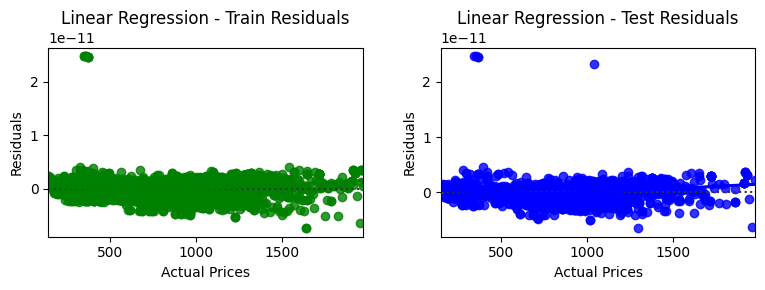

Training Decision Tree...


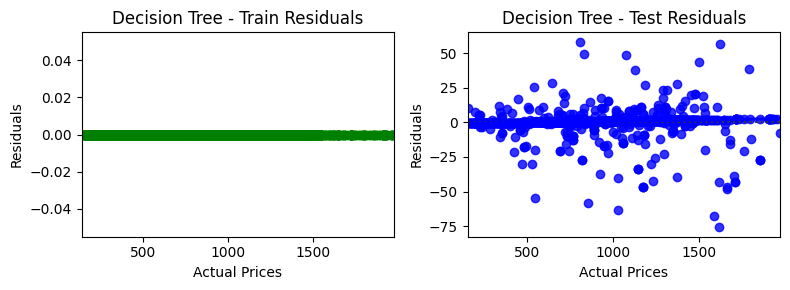

Training Gaussian Process...


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


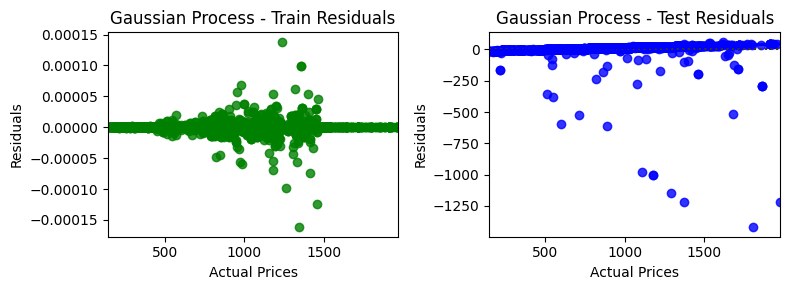

Training Random Forest...


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
137 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py"

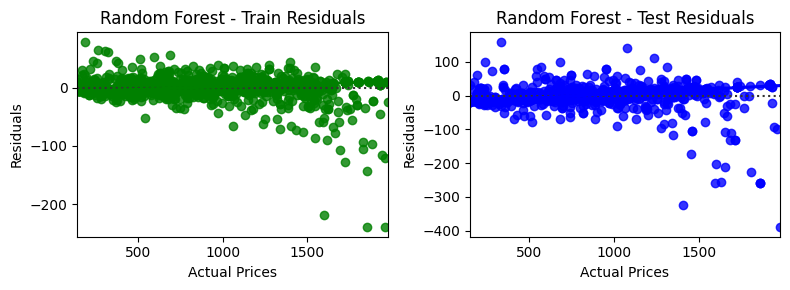

Training Gradient Boosting...


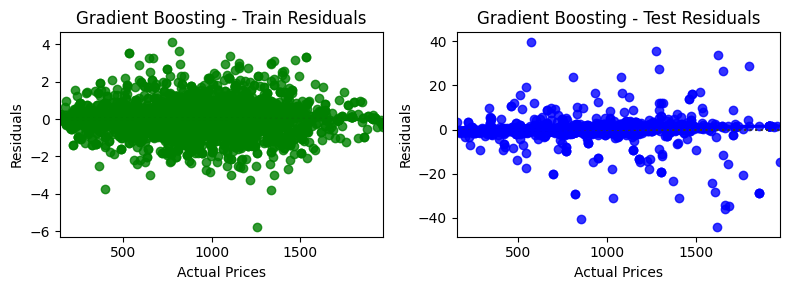

Training AdaBoost...


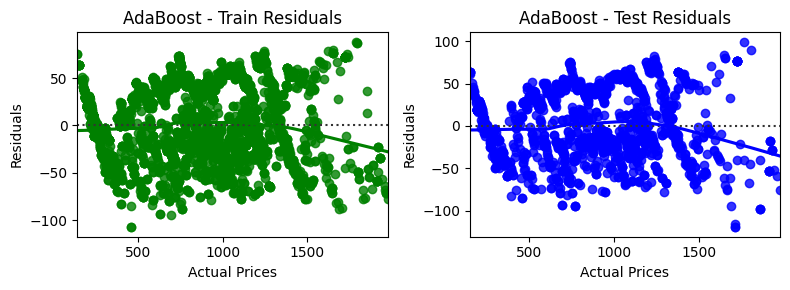

               Model                                        Best Params  \
0  Linear Regression         {'fit_intercept': False, 'positive': True}   
1      Decision Tree  {'criterion': 'absolute_error', 'max_depth': N...   
2   Gaussian Process             {'kernel': 1**2 * RBF(length_scale=1)}   
3      Random Forest  {'max_depth': None, 'max_features': 'sqrt', 'm...   
4  Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...   
5           AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   

     Train RMSE     Test RMSE     Train MAE      Test MAE  Train R2   Test R2  
0  4.132977e-12  4.247688e-12  3.404475e-12  3.448705e-12  1.000000  1.000000  
1  0.000000e+00  8.435842e+00  0.000000e+00  2.476602e+00  1.000000  0.999526  
2  8.288687e-06  9.390557e+01  2.404287e-06  1.181389e+01  1.000000  0.941307  
3  1.404726e+01  3.448708e+01  4.897299e+00  1.277465e+01  0.998643  0.992084  
4  8.100336e-01  5.293023e+00  5.690304e-01  2.079482e+00  0.999995  0.999

In [134]:
results_df_booking = train_and_evaluate_models(X_booking, y_booking)
print(results_df_booking)